In [39]:

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense
from keras import optimizers



#from keras.models import EfficientNet
import efficientnet.keras as efn 


In [40]:
train_dir = "/home/hasan/Data Set/aerial-cactus-identification/train"
test_dir = "/home/hasan/Data Set/aerial-cactus-identification/test/"

train_df = pd.read_csv('/home/hasan/Data Set/aerial-cactus-identification/train.csv')
train_df.head()


,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


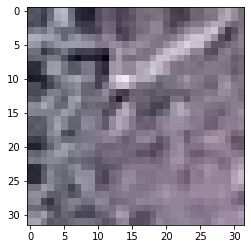

In [41]:
im = cv2.imread("/home/hasan/Data Set/aerial-cactus-identification/train/01e30c0ba6e91343a12d2126fcafc0dd.jpg")
plt.imshow(im)



In [42]:
eff_net = efn.EfficientNetB3(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [43]:
eff_net.trainable = False
# model.summary()

In [45]:
x = eff_net.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)
model = Model(inputs = eff_net.input, outputs = predictions)


In [46]:
optimizer = keras.optimizers.RMSprop(
    learning_rate=0.0001,  name='RMSprop', decay=.000006)

model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])




In [47]:
X_tr = []
Y_tr = []
imges = train_df['id'].values
for img_id in tqdm_notebook(imges):
    X_tr.append(cv2.imread(train_dir + img_id))    
    Y_tr.append(train_df[train_df['id'] == img_id]['has_cactus'].values[0])  
X_tr = np.asarray(X_tr)
X_tr = X_tr.astype('float32')
X_tr /= 255
Y_tr = np.asarray(Y_tr)


<ipython-input-47-6597ad4cbb31>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_id in tqdm_notebook(imges):


In [48]:
batch_size = 111
nb_epoch = 25


In [ ]:
# Train model
history = model.fit(X_tr, Y_tr,
              batch_size=batch_size,
              epochs=nb_epoch,
              validation_split=0.1,
              shuffle=True,
              verbose=2)


In [ ]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()


In [ ]:
X_tst = []
Test_imgs = []
for img_id in tqdm_notebook(os.listdir(test_dir)):
    X_tst.append(cv2.imread(test_dir + img_id))     
    Test_imgs.append(img_id)
X_tst = np.asarray(X_tst)
X_tst = X_tst.astype('float32')
X_tst /= 255



In [ ]:
# Prediction
test_predictions = model.predict(X_tst)


In [ ]:
sub_df = pd.DataFrame(test_predictions, columns=['has_cactus'])
sub_df['has_cactus'] = sub_df['has_cactus'].apply(lambda x: 1 if x > 0.75 else 0

In [ ]:
sub_df['id'] = ''
cols = sub_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
sub_df=sub_df[cols]


In [ ]:
for i, img in enumerate(Test_imgs):
    sub_df.set_value(i,'id',img)


In [ ]:
sub_df.head()


In [ ]:
sub_df.to_csv('submission.csv',index=False)